# Flight Analysis

In this notebook, we applied data analysis and machine learning techniques to real flight data.
Our objective was to explore, clean, and visualize the dataset to uncover meaningful insights about flight delays, airport performance, and overall flight patterns.
We then developed and evaluated predictive models to estimate the likelihood of flight delays with the goal of improving operational understanding and decision-making.

### Possible questions:

`1.` What drives flight delays? (by airline, origin, destination, time of day)

`2.` Which routes are most/least reliable?

`3.` Seasonal or daily patterns in cancellations or delays

`4.` Are there clusters of similar airports/routes?

`5.` Predict whether a flight will be delayed


### Sumary

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from modules.flight_preprocessor import FlightPreprocessor
from modules.airport_analyzer import AirportAnalyzer

In [2]:
df_flights = pd.read_csv("./data/flights.csv", low_memory=False)

# Set the columns to lower case
df_flights.columns = df_flights.columns.str.lower()
df_flights = df_flights.fillna(0)

In [3]:
df_flights.head()

,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,...,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,0,0.0,0.0,0.0,0.0,0.0
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,0,0.0,0.0,0.0,0.0,0.0
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,0,0.0,0.0,0.0,0.0,0.0
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,0,0.0,0.0,0.0,0.0,0.0
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,0,0.0,0.0,0.0,0.0,0.0


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>
#### `1.` What is the distribution and correlation of the main flight variables, such as departure delay, arrival delay, distance, and airtime?

##### Undestranding the correlation of the flight variables

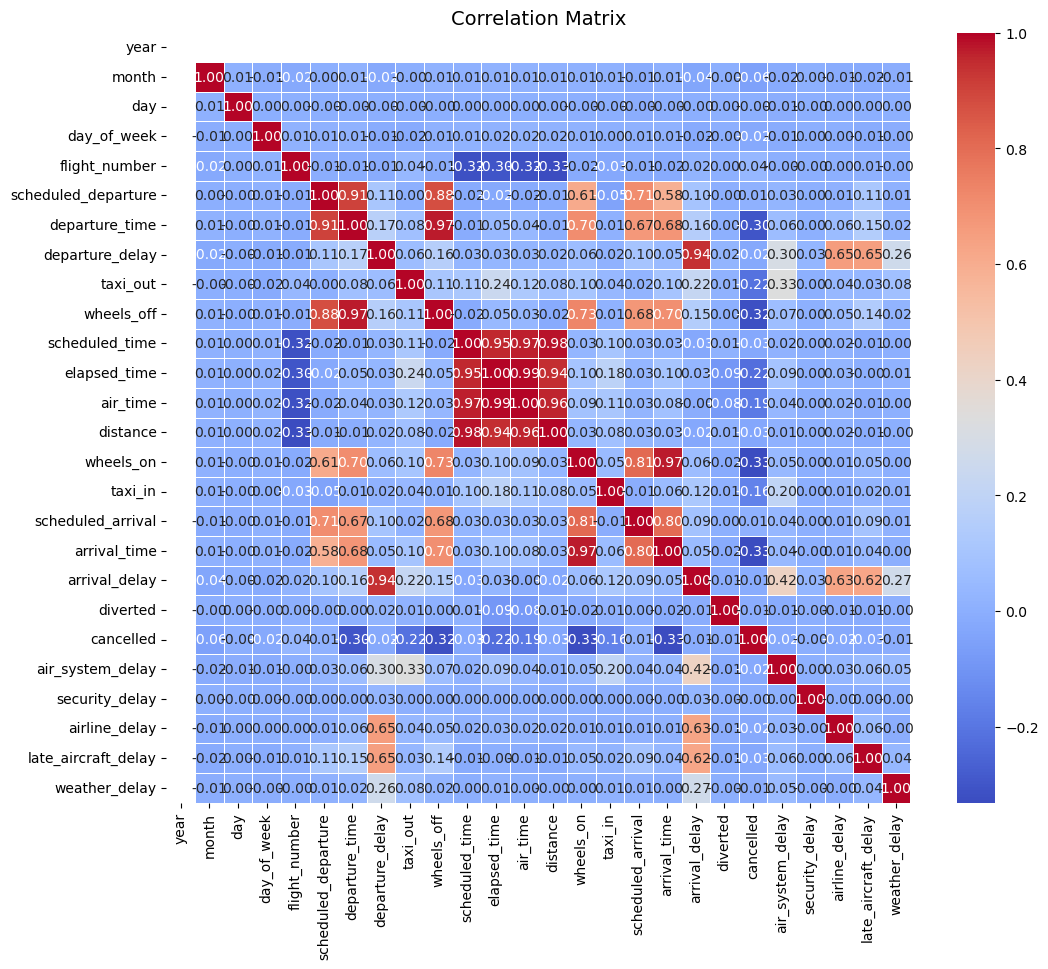

In [4]:
corr = df_flights.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix", fontsize=14)
plt.show()

### Understanding Variable Correlation

#### Variables with Strong Correlation

Several variables exhibit strong correlations, indicating that they carry redundant or overlapping information.
In other words, they describe similar aspects of the same underlying phenomenon.
To address this, it may be useful to apply dimensionality reduction, either by removing duplicate variables or by combining multiple attributes into a single representative feature.
Some examples include:

- arrival_delay ↔ departure_delay
- schedule_time ↔ elapsed_time ↔ air_time ↔ distance
- arrival_time ↔ wheels_on ↔ scheduled_arrival ↔ wheels_off
- late_aircraft_delay ↔ arrival_delay ↔ airline_delay

Reducing redundancy helps simplify the dataset, improve model interpretability, and prevent overfitting in predictive modeling.

#### Variables with Weak or No Correlation

On the other hand, variables with weak or no correlation show little to no direct relationship between each other.
These features may not significantly contribute to predictive models and could be candidates for removal after further analysis. Examples include:

- flight_number ↔ distance
- flight_number ↔ air_time
- flight_number ↔ elapsed_time
- flight_number ↔ schedule_time

Some relationships also appear weak because the events do not occur together logically — for instance, a canceled flight will not have data for variables related to physical movement:

- cancelled ↔ departure_time
- cancelled ↔ taxi_out
- cancelled ↔ wheels_off
- cancelled ↔ wheels_on
- cancelled ↔ arrival_time

Variable that can be removed:
- flight_number
- wheels_on
- wheels_off
- cancellation_reason

In [5]:
variables_to_remove = ['flight_number', 'wheels_on', 'wheels_off', 'cancellation_reason']
df_flights = df_flights.drop(columns=variables_to_remove)

##### Undestranding the distribution of the scheduled, departure and arrival

In [6]:
df_schedules = df_flights[
    (df_flights['diverted'] == 0) & 
    (df_flights['cancelled'] == 0)
][[
    'year', 'month', 'day', 'day_of_week',
    'scheduled_departure', 
    'departure_time', 
    'departure_delay', 
    'scheduled_arrival', 
    'arrival_time', 
    'arrival_delay'
]]
processor = FlightPreprocessor()
df_schedules = processor.preprocess(df_schedules)

In [7]:
# Compute delay metrics
df_schedules['dep_delay_min'] = (df_schedules['departure_time'] - df_schedules['scheduled_departure']).dt.total_seconds() / 60
df_schedules['arr_delay_min'] = (df_schedules['arrival_time'] - df_schedules['scheduled_arrival']).dt.total_seconds() / 60

# Additional derived features
df_schedules['day_of_week'] = df_schedules['scheduled_departure'].dt.day_name()
df_schedules['hour'] = df_schedules['scheduled_departure'].dt.hour
df_schedules['is_delayed'] = df_schedules['dep_delay_min'] > 15

df_schedules['scheduled_hour'] = df_schedules['scheduled_departure'].dt.hour
df_schedules['departure_hour'] = df_schedules['departure_time'].dt.hour
df_schedules['arrival_hour'] = df_schedules['arrival_time'].dt.hour


In [8]:
df_schedules.head()

,year,month,day,day_of_week,scheduled_departure,departure_time,departure_delay,scheduled_arrival,arrival_time,arrival_delay,dep_delay_min,arr_delay_min,is_delayed,hour,scheduled_hour,departure_hour,arrival_hour
0,2015,1,1,Thursday,2015-01-01 00:05:00,2014-12-31 23:54:00,-11.0,2015-01-01 04:30:00,2015-01-01 04:08:00,-22.0,-11.0,-22.0,False,0,0,23,4
1,2015,1,1,Thursday,2015-01-01 00:10:00,2015-01-01 00:02:00,-8.0,2015-01-01 07:50:00,2015-01-01 07:41:00,-9.0,-8.0,-9.0,False,0,0,0,7
2,2015,1,1,Thursday,2015-01-01 00:20:00,2015-01-01 00:18:00,-2.0,2015-01-01 08:06:00,2015-01-01 08:11:00,5.0,-2.0,5.0,False,0,0,0,8
3,2015,1,1,Thursday,2015-01-01 00:20:00,2015-01-01 00:15:00,-5.0,2015-01-01 08:05:00,2015-01-01 07:56:00,-9.0,-5.0,-9.0,False,0,0,0,7
4,2015,1,1,Thursday,2015-01-01 00:25:00,2015-01-01 00:24:00,-1.0,2015-01-01 03:20:00,2015-01-01 02:59:00,-21.0,-1.0,-21.0,False,0,0,0,2


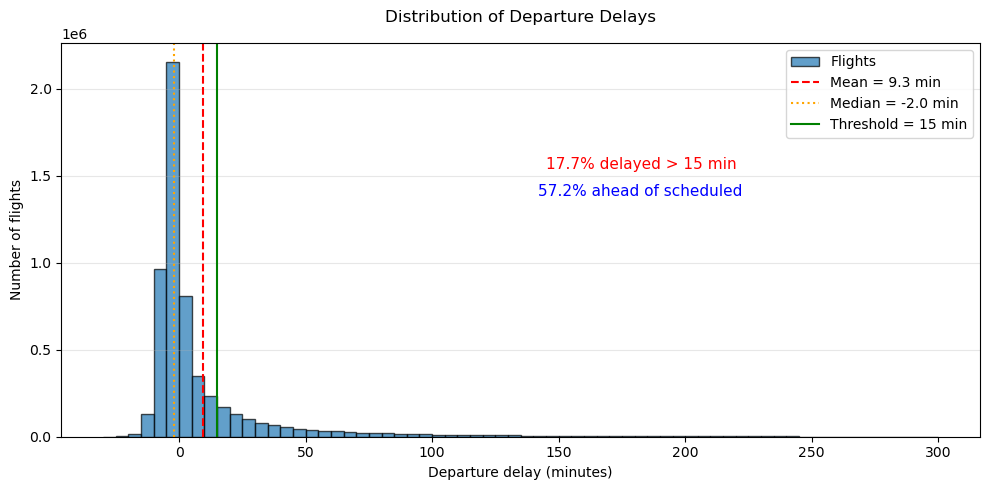

In [9]:
delays = df_schedules['dep_delay_min'].dropna()
threshold = 15  # delay threshold in minutes

plt.figure(figsize=(10, 5))
plt.hist(
    delays,
    bins=np.arange(-30, 301, 5),
    color="#1f77b4",
    alpha=0.7,
    edgecolor="black",
    label="Flights"
)

# Mean and median
mean_delay = delays.mean()
median_delay = delays.median()
plt.axvline(mean_delay, color='red', linestyle='--', linewidth=1.5, label=f"Mean = {mean_delay:.1f} min")
plt.axvline(median_delay, color='orange', linestyle=':', linewidth=1.5, label=f"Median = {median_delay:.1f} min")

# Delay threshold
plt.axvline(threshold, color='green', linestyle='-', linewidth=1.5, label=f"Threshold = {threshold} min")

# Label, title, etc.
plt.xlabel('Departure delay (minutes)')
plt.ylabel('Number of flights')
plt.title('Distribution of Departure Delays', pad=15)

# % of delayed flights
delayed_pct = (delays > threshold).mean() * 100

plt.text(
    145, plt.ylim()[1] * 0.68,
    f"{delayed_pct:.1f}% delayed > {threshold} min",
    color="red", fontsize=11
)

# % of ahead of scheduled flights
ahead_scheduled_pct = (delays < 0).mean() * 100
plt.text(
    142, plt.ylim()[1] * 0.61,
    f"{ahead_scheduled_pct:.1f}% ahead of scheduled",
    color="blue", fontsize=11
)

plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Understanding Flight Delays

By exploring the dataset, we can observe that most flights actually arrive ahead of schedule, representing nearly 60% of all records.
This indicates that early or on-time arrivals are more common than significant delays.

However, there is also a notable portion of flights, approximately 17%, that experience delays exceeding 15 minutes. These cases are particularly important to analyze, as they can reveal operational inefficiencies, weather-related impacts, or airline-specific issues that contribute to longer delays.

On average, flights tend to arrive 7.3 minutes early (mean  -7.3), and the median delay is around -2 minutes, reinforcing the idea that early arrivals are typical, but extreme delay cases still occur and deserve closer investigation.

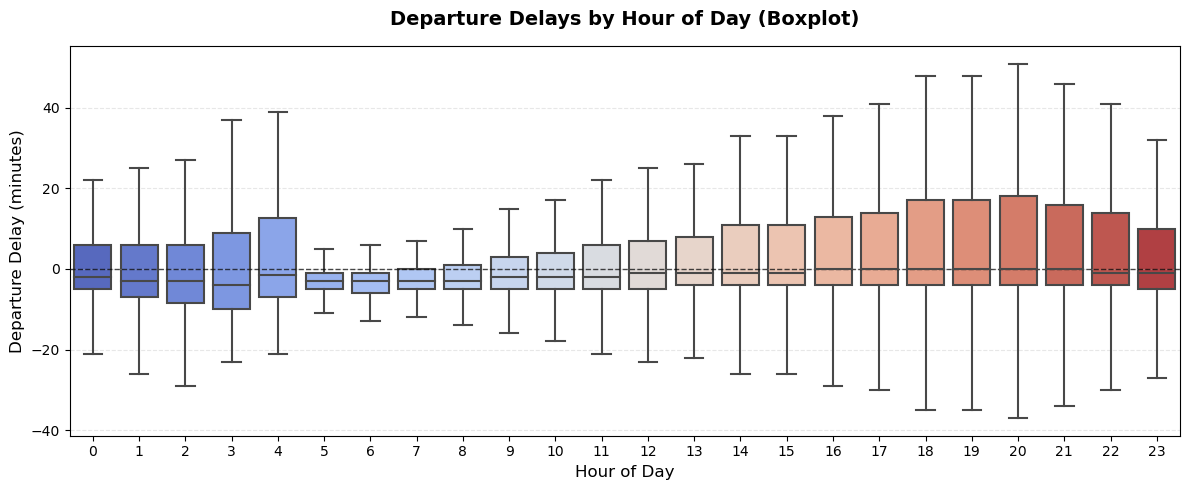

In [10]:
plt.figure(figsize=(12, 5))
sns.boxplot(
    x='hour',
    y='dep_delay_min',
    data=df_schedules,
    showfliers=False, 
    palette='coolwarm'
)

plt.title('Departure Delays by Hour of Day (Boxplot)', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Departure Delay (minutes)', fontsize=12)

plt.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()



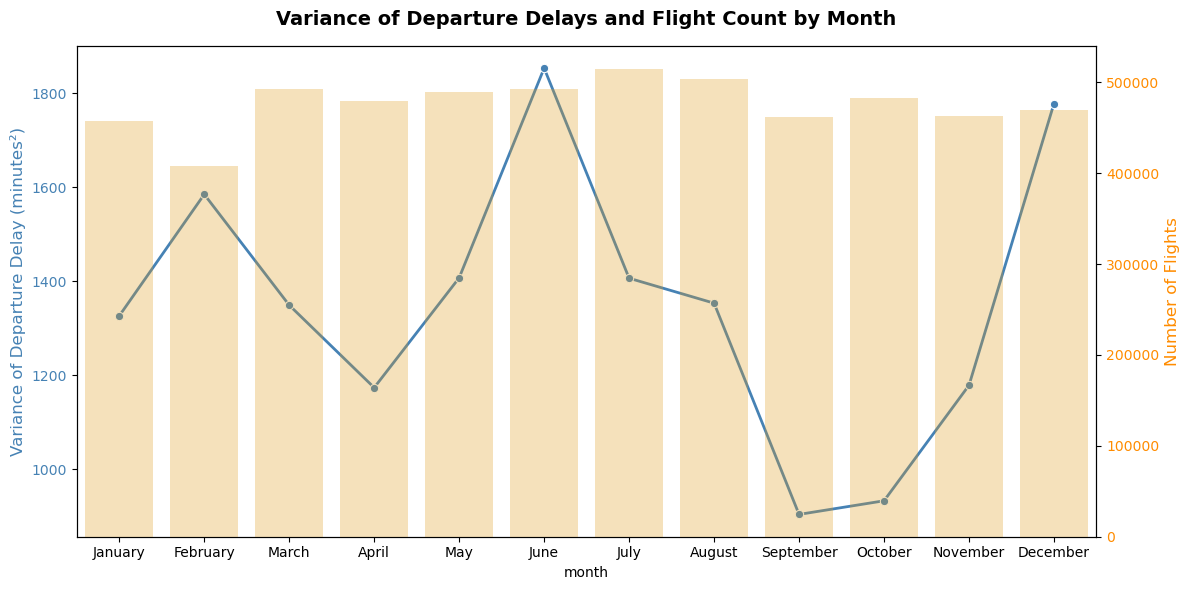

In [11]:
df_schedules['month'] = df_schedules['scheduled_departure'].dt.month_name()
monthly_stats = (
    df_schedules.groupby('month')['dep_delay_min']
    .agg(['var', 'count'])
    .reset_index()
)

month_order = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]

monthly_stats['month'] = pd.Categorical(monthly_stats['month'], categories=month_order, ordered=True)
monthly_stats = monthly_stats.sort_values('month')

fig, ax1 = plt.subplots(figsize=(12, 6))

# Variance
sns.lineplot(
    data=monthly_stats,
    x='month',
    y='var',
    marker='o',
    color='steelblue',
    linewidth=2,
    ax=ax1
)
ax1.set_ylabel('Variance of Departure Delay (minutes²)', color='steelblue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='steelblue')

# Flight count
ax2 = ax1.twinx()
sns.barplot(
    data=monthly_stats,
    x='month',
    y='count',
    alpha=0.3,
    color='orange',
    ax=ax2
)
ax2.set_ylabel('Number of Flights', color='darkorange', fontsize=12)
ax2.tick_params(axis='y', labelcolor='darkorange')

plt.title('Variance of Departure Delays and Flight Count by Month', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Month', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


`2.` Which airports and airlines have the highest frequency of delays?

In [12]:
df_airports = pd.read_csv("./data/airports.csv", low_memory=False)
df_airports.columns = df_airports.columns.str.lower()
df_airports = df_airports[['iata_code', 'latitude','longitude', 'city', 'state', 'country']]
df_airport_flights = df_flights[
    (df_flights['diverted'] == 0) & 
    (df_flights['cancelled'] == 0)
][['origin_airport','destination_airport', 'month']]

In [20]:
analyzer = AirportAnalyzer(df_flights, df_airports)
airport_metrics = analyzer.compute_airport_metrics()
airport_metrics.tail(15)

,iata_code,latitude,longitude,city,state,country,departures,arrivals,total_flights,avg_arrival_delay,avg_departure_delay
307,CNY,38.75496,-109.75484,Moab,UT,USA,206.0,206,412.0,-11.519417,-6.029126
308,VEL,40.44090,-109.50992,Vernal,UT,USA,206.0,205,411.0,-13.224390,-3.631068
309,MVY,41.39303,-70.61433,Marthas Vineyard,MA,USA,205.0,205,410.0,1.785366,25.907317
310,CEC,41.78016,-124.23653,Crescent City,CA,USA,190.0,190,380.0,3.942105,15.947368
311,MMH,37.62405,-118.83777,Mammoth Lakes,CA,USA,156.0,156,312.0,7.967949,8.903846
312,UST,NaN,NaN,St. Augustine,FL,USA,155.0,155,310.0,1.819355,15.206452
313,PPG,14.33102,-170.71053,Pago Pago,AS,USA,107.0,107,214.0,7.401869,15.102804
314,ILG,39.67872,-75.60653,Wilmington,DE,USA,100.0,98,198.0,21.316327,28.510000
315,ADK,51.87796,-176.64603,Adak,AK,USA,96.0,96,192.0,-2.958333,9.885417
316,HYA,41.66934,-70.28036,Hyannis,MA,USA,83.0,83,166.0,3.469880,22.903614


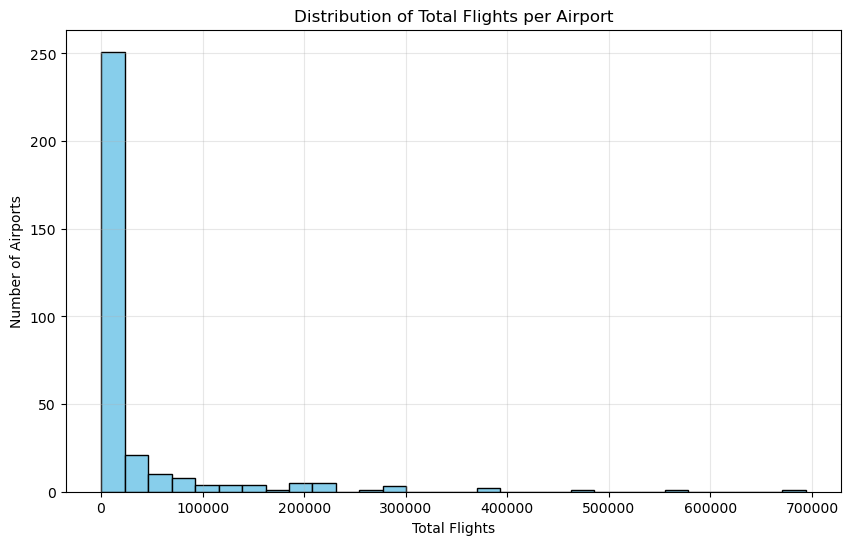

In [21]:
plt.figure(figsize=(10, 6))
plt.hist(analyzer.df_metrics['total_flights'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Total Flights per Airport')
plt.xlabel('Total Flights')
plt.ylabel('Number of Airports')
plt.grid(alpha=0.3)
plt.show()

In [ ]:
flights_per_month = (
    df_flights['month']
    .value_counts()
    .sort_index()
    .rename_axis('month')
    .reset_index(name='num_flights')
)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(flights_per_month['month'].astype(str), flights_per_month['num_flights'], marker='o')
plt.title('Number of Flights per Month')
plt.xlabel('Month')
plt.ylabel('Number of Flights')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


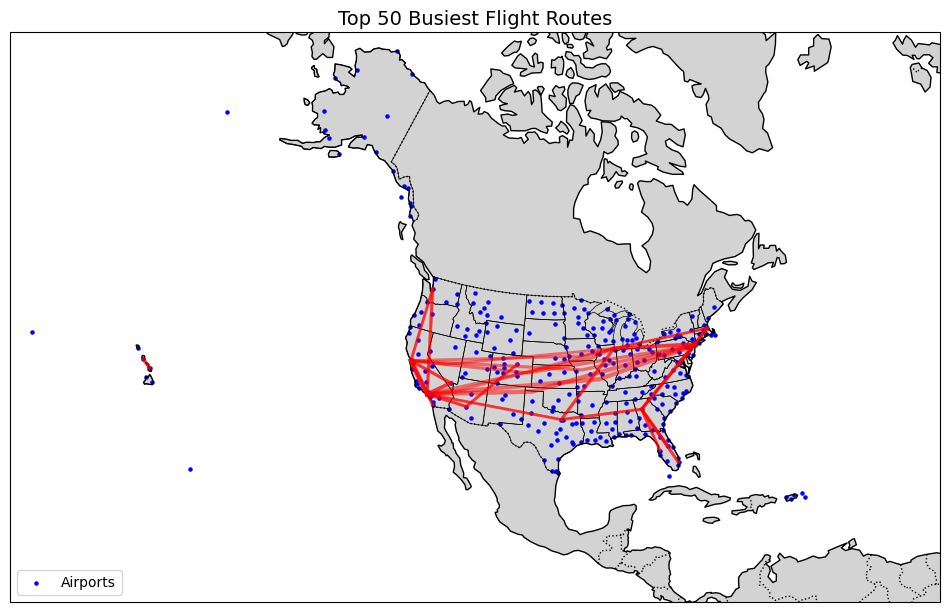

In [14]:
analyzer.plot_top_routes(top_n=50)

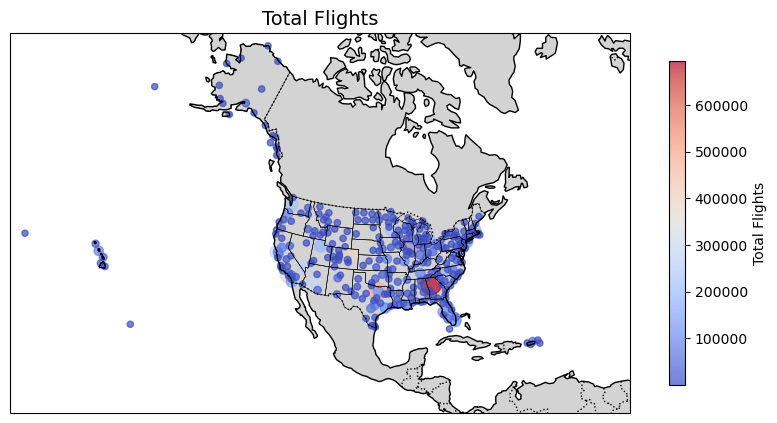

In [15]:
analyzer.plot_airports('total_flights', title='Total Flights')

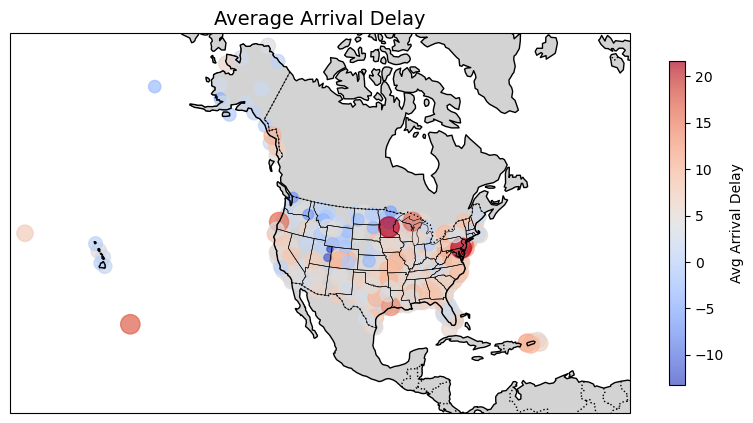

In [18]:
analyzer.plot_airports('avg_arrival_delay', title='Average Arrival Delay')

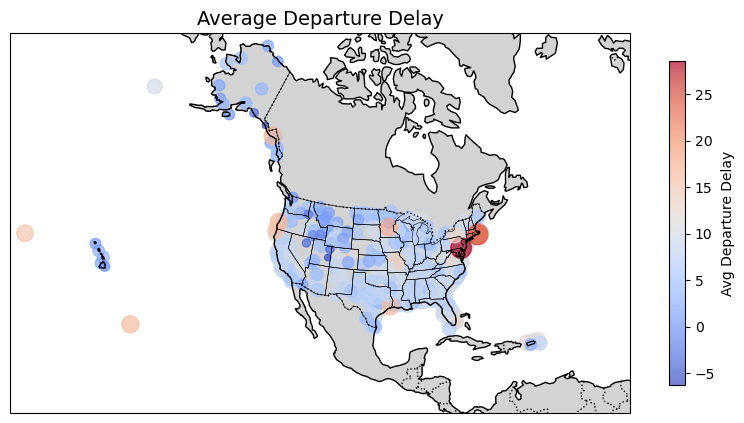

In [17]:
analyzer.plot_airports('avg_departure_delay', title='Average Departure Delay')

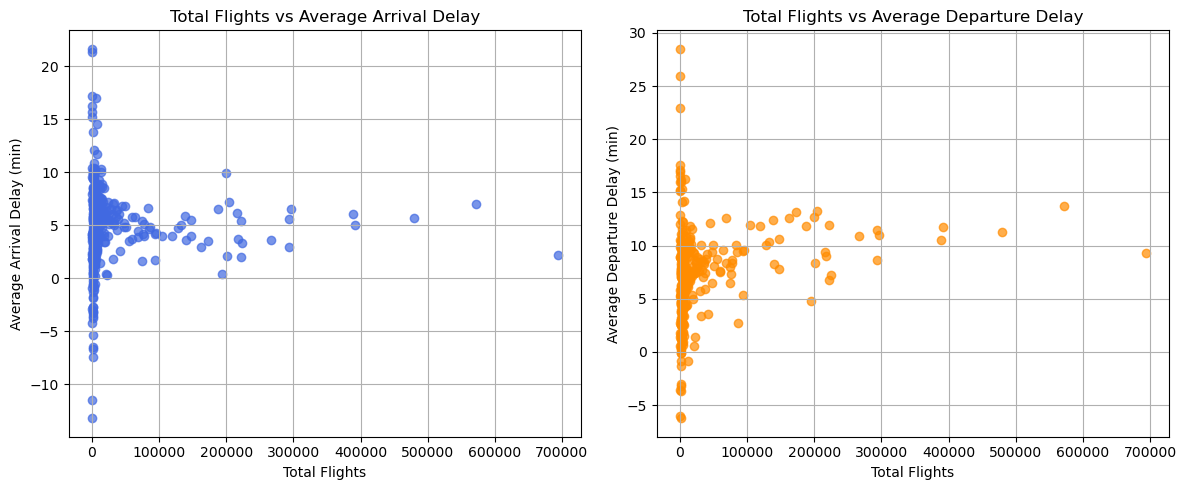

In [19]:
# Correlation values
corr_arrival = airport_metrics['total_flights'].corr(airport_metrics['avg_arrival_delay'])
corr_departure = airport_metrics['total_flights'].corr(airport_metrics['avg_departure_delay'])

plt.figure(figsize=(12,5))

# --- Arrival Delay ---
plt.subplot(1, 2, 1)
plt.scatter(airport_metrics['total_flights'], airport_metrics['avg_arrival_delay'], alpha=0.7, color='royalblue')
plt.title('Total Flights vs Average Arrival Delay')
plt.xlabel('Total Flights')
plt.ylabel('Average Arrival Delay (min)')
plt.grid(True)

# --- Departure Delay ---
plt.subplot(1, 2, 2)
plt.scatter(airport_metrics['total_flights'], airport_metrics['avg_departure_delay'], alpha=0.7, color='darkorange')
plt.title('Total Flights vs Average Departure Delay')
plt.xlabel('Total Flights')
plt.ylabel('Average Departure Delay (min)')
plt.grid(True)

plt.tight_layout()
plt.show()



`3.` Are there specific times of day, days of the week, or months associated with more delays?